In [17]:
# Basic libraries
import numpy as np
import matplotlib.pyplot as plt

# Visualization libraries
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
from matplotlib import animation

Let's define all the functions we are going to use:

In [18]:
def initial_loc_vel_assigner(Natoms, targets, p1, p2, m1, m2, r1, r2, q1, q2):
    # Assign initial positions, velocities, color for display, mass, radius and charge to the particles inside the dictonary
    particles_properties = {i:[] for i in range(Natoms)}
    for i in range(Natoms):
        x = np.random.normal(loc = 0.0, scale = 2*Rbeam)
        y = np.random.normal(loc = 0.0, scale = Rbeam)
        z = np.random.normal(loc = 0.0, scale = Rbeam)
        if i < Natoms-targets:
            # Particles in the beam 1
            particles_properties[i] = [np.array([x-L, y, z]), np.array([p1, 0, 0]), 'b', m1, r1, q1]
        else:
            # Particles in the beam 2
            particles_properties[i] = [np.array([x+L, y, z]), np.array([p2, 0, 0]), 'r', m2, r2, q2]
    return particles_properties

In [3]:
def checkCollisions(Natoms, particles_properties):
    # Check for collisions between particles
    hitlist = []
    for i in particles_properties:
        ai = particles_properties[i][0]
        for j in particles_properties:
            if j <i:
                aj = particles_properties[j][0]
                r2 = particles_properties[j][4] + particles_properties[i][4]
                dr = ai - aj
                # If two particles are closer than the sum of their radius, we add them in the list
                if np.linalg.norm(dr) < r2: hitlist.append([i,j])
    return np.array(hitlist)

In [19]:
def pos_update(particles_properties):
    global colisions
    
    for i in particles_properties:
        # Update positions of particles
        particles_properties[i][0] = particles_properties[i][0] + dt*particles_properties[i][1]/particles_properties[i][3]
        # Update momentum of particles
        particles_properties[i][1] = particles_properties[i][1] + dt*lorentz_force(particles_properties[i][5], particles_properties[i][1], B, particles_properties[i][3])
    
    for index in particle_track:
        # Keep track of particles that have colided
        particle_trajectory.append([particles_properties[int(index)][0].tolist(),int(index)])
    
    hitlist = checkCollisions(Natoms, particles_properties)
    
    for ij in hitlist:
        i = ij[0]
        j = ij[1]
        # Relative positions and velocities
        vrel = particles_properties[j][1]/particles_properties[j][3]-particles_properties[i][1]/particles_properties[i][3]
        rrel = particles_properties[i][0]-particles_properties[j][0]
        # If the relative velocity is not zero and they are not really overlaping, we consider them as a colision
        if np.linalg.norm(vrel)**2 == 0: continue; 
        if np.linalg.norm(rrel) > particles_properties[i][4] + particles_properties[j][4]: continue 
        colisions = colisions + 1
        # We add the colided particles and their positions into a list
        particle_track.append(i)
        particle_track.append(j)
        particle_trajectory.append([particles_properties[i][0].tolist(),i])
        particle_trajectory.append([particles_properties[j][0].tolist(),j])
        # We compute the momentum and direction of the particles after the colision 
        particles_properties  = colision_resolver(i, j, particles_properties) 
        particle_trajectory.append([particles_properties[i][0].tolist(),i])
        particle_trajectory.append([particles_properties[j][0].tolist(),j])
    return particles_properties

In [35]:
def colision_resolver(i, j, particles_properties):
    global muons
    
    ptot = particles_properties[i][1]+particles_properties[j][1]
    pos_i = particles_properties[i][0]
    pos_j = particles_properties[j][0]
    vi = particles_properties[i][1]/particles_properties[i][3]
    vj = particles_properties[j][1]/particles_properties[j][3]
    vrel = vj-vi
    rrel = pos_i-pos_j
    # first we move the particles to the colision point 
    # theta is the angle between vrel and rrel:
    dx = np.dot(rrel, vrel/np.linalg.norm(vrel))       # rrel.mag*cos(theta)
    dy = np.linalg.norm(np.cross(rrel, vrel/np.linalg.norm(vrel))) # rrel.mag*sin(theta)
    # alpha is the angle of the triangle composed of rrel, path of atom j, and a line
    #   from the center of atom i to the center of atom j where atome j hits atom i:
    alpha = np.arcsin(dy/(particles_properties[i][4] + particles_properties[j][4])) 
    d = (particles_properties[i][4] + particles_properties[j][4])*np.cos(alpha)-dx # distance traveled into the atom from first contact
    deltat = d/np.linalg.norm(vrel)         # time spent moving from first contact to position inside atom
    pos_i = pos_i-vi*deltat # back up to contact configuration
    pos_j = pos_j-vj*deltat
    # now we can calculate the direction and magnitude of the new velocity
    mtot = particles_properties[i][3] + particles_properties[j][3]
    pcmi = particles_properties[i][1] - ptot*particles_properties[i][3]/mtot # transform momenta to cm frame
    pcmj = particles_properties[j][1] - ptot*particles_properties[j][3]/mtot
    rrel = rrel/np.linalg.norm(rrel)
    pcmi = pcmi-2*np.dot(pcmi, rrel)*rrel # bounce in cm frame
    pcmj = pcmj-2*np.dot(pcmj, rrel)*rrel
    
    scm = 2*(2*np.pi/(s-1))*np.dot(particles_properties[i][1], particles_properties[j][1])
    if abs(scm) > 2*mu and (particles_properties[i][3] != mu and particles_properties[j][3] != mu):
        muons = muons + 1
        particles_properties[i][3] = mu
        particles_properties[j][3] = mu
        particles_properties[i][4] = Ru
        particles_properties[j][4] = Ru
        particles_properties[i][1] = pcmi + ptot*particles_properties[i][3]/mtot  # return to lab frame
        particles_properties[j][1] = pcmj + ptot*particles_properties[j][3]/mtot 
        # Cyan and yellow are the resulting muon and antimuon
        particles_properties[i][2] = 'cyan'
        particles_properties[j][2] = 'yellow'
    else:
        particles_properties[i][1] = pcmi + ptot*particles_properties[i][3]/mtot # return to lab frame
        particles_properties[j][1] = pcmj + ptot*particles_properties[j][3]/mtot
        # Blue and red are the resulting electron and positorn
        particles_properties[i][2] = 'blue'
        particles_properties[j][2] = 'red'    
        
    # move forward deltat in time to match the time we have skipped
    particles_properties[i][0] = pos_i + (particles_properties[i][1]/particles_properties[i][3])*deltat 
    particles_properties[j][0] = pos_j + (particles_properties[j][1]/particles_properties[j][3])*deltat
    return particles_properties

We want to display a move of the particle beam coliding and the particle results

In [29]:
def Animation(frame):
    global particles_properties
    global dt
    
    particles_properties = pos_update(particles_properties)
    
    # Plot the positions of every atom
    x = [particles_properties[i][0][0] for i in particles_properties]
    y = [particles_properties[i][0][1] for i in particles_properties]
    z = [particles_properties[i][0][2] for i in particles_properties]
    color_array = [particles_properties[i][2] for i in particles_properties]

    # Plot the 
    trajectories = {i:[] for i in particle_track}
    for i in particle_trajectory: trajectories[i[1]].append(i[0])
        
    ax.clear()
    plot_geeks = ax.scatter(x, y, z, marker='o', color = color_array)  
    for index in particle_track:
        ax.plot([item[0] for item in trajectories[index]], [item[1] for item in trajectories[index]], [item[2] for item in trajectories[index]], color = particles_properties[index][2], linestyle='dashed')
    
    ax.set_title("Time = {:.2f}".format(frame*dt))
    ax.scatter(10, 10, 10, marker='o', color = 'b', label = 'Electron')  
    ax.scatter(10, 10, 10, marker='o', color = 'r', label = 'Positron')  
    ax.scatter(10, 10, 10, marker='o', color = 'cyan', label = 'Antimuon')  
    ax.scatter(10, 10, 10, marker='o', color = 'yellow', label = 'Muon')  
    ax.legend()
    ax.set_xlabel('x-axis')
    ax.set_ylabel('y-axis')
    ax.set_zlabel('z-axis')
    ax.axes.set_xlim3d(left = -(L+Rbeam), right = (L+Rbeam)) 
    ax.axes.set_ylim3d(bottom = -(L+Rbeam), top = (L+Rbeam))
    ax.axes.set_zlim3d(bottom = -(L+Rbeam), top = (L+Rbeam))
    plt.show()

In [7]:
def lorentz_force(q, p, B, mass):
    v = p/mass
    return q * np.cross(v, B)


Our code allows us to change almost all the parameters in the simulations

In [40]:
Natoms = 50 # Total number of particles
targets = int(Natoms/2) # How many particles are going to be in the second beam

Rbeam = 0.5 # If the beam follows a gaussian distribution is the standard seviation. 
# If not, it's the radius of the sphere containing all the particles

L = 5  # The distance between the two beems. Must be bigger than Rbeam

me = 1 # simplified electron mass
mu = 2 # simplified muon mass
Re = 0.1 # projectile radius (left beam particle radius)
Ru = 0.1 # target radius (right beam particle radius)
dt =  2*Re*me/p1 # Optimized timestep to avoid crossing from high speed particles

T = int(((2*L-2*Rbeam)*me/(p1*dt))) # Total time of the simulation. Is set to be the optimal time when the two beams 
# cross each other and we consider all the possible collisions took place

p1 = 2 #Left beam particle initial momentum
p2 = -2 #Right beam particle initial momentum

q1 = -1 # Simplified left beam particle charge
q2 = 1 # Simplified left beam particle charge

B = np.array([0, 0, 0.09]) # Magnetic field 

s = 2*(abs(p1*p2)) #Energy Mandelstam variables



Number of colisions occurred: 0
Number of muon creations: 0


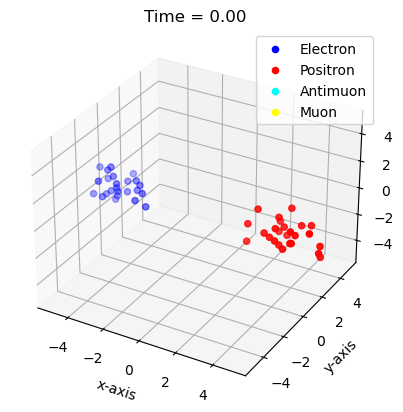

In [41]:
colisions = 0 # Colisions counter
muons = 0 # Muons couter

#We first assign the initial properties to all atoms
particles_properties = initial_loc_vel_assigner(Natoms, targets, p1, p2, me, me, Re, Re, q1, q2)

# Delete the particles that where overlaping in the begining
# We found this overlaping
hitlist = checkCollisions(Natoms, particles_properties)

# Then, we delete them from de dictionary
if len(hitlist) > 0:
    for i in hitlist[:,0]: 
        if i in particles_properties: 
            particles_properties.pop(i) 
            
# And we redefine the total number of atoms
Natoms = len(particles_properties)

# We want to store which particles have colided and their trajectories for better display
particle_track = []
particle_trajectory = []

# We make the animation

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ani = animation.FuncAnimation(fig, Animation, frames = int(T*1.5), interval=50, repeat=False)

print('Number of colisions occurred:', colisions)
print('Number of muon creations:', muons)

# Display the animation using HTML
HTML(ani.to_jshtml())

# f = r"c://Users/Guillem/Desktop/animation.gif" 
# writergif = animation.PillowWriter(fps = 15) 
# ani.save(f, writer=writergif)